In [1]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback,CustomCallbackAcc
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)

def set_seed():
    SEED =3
    os.environ['PYTHONHASHSEED']=str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.config.threading.set_inter_op_parallelism_threads(1)

def split_dataset(x,y):
        split_ratio=0.25
        split_point_x = int(len(x) * split_ratio)
        split_point_y = int(len(y) * split_ratio)

        x_test = x[:split_point_x]
        y_test = y[:split_point_y]
        x_train = x[split_point_x:]
        y_train = y[split_point_y:]
        split_ratio = 0.5

        split_point_x = int(len(x_test) * split_ratio)
        split_point_y = int(len(y_test) * split_ratio)


        x_val = x_test[:split_point_x]
        y_val = y_test[:split_point_x]
        x_test = x_test[split_point_x:]
        y_test = y_test[split_point_x:]
        return  (x_train,y_train,x_val,y_val,x_test,y_test)
    
set_seed()
gridsize=10
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]
x_values = [[int(bit) for bit in seq] for seq in x_values]
num_classes = 2  
num_filters=1

loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                                                 tf.reshape(y, shape=(-1, num_classes)) ,from_logits=True)



(1024, 3, 10)
(1024, 3, 1)
x_train shape: (768, 10, 1) y_train shape: (768, 10, 2) x_val shape: (128, 10, 1) y_val shape: (128, 10, 2) x_test shape: (128, 10, 1) y_test shape: (128, 10, 2)


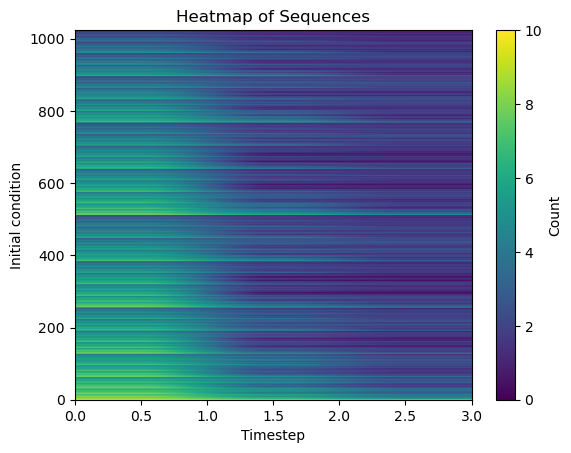

In [2]:
MEMORY_CONSTANT=1
sequence_length=MEMORY_CONSTANT*2
 
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

ca.set_rule_number(130)
sequences= np.array(ca.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print(sequences.shape)
collapsed_sequences=collapse_sequences(sequences)
print(collapsed_sequences.shape)

collapsed_sequences_2d = np.squeeze(collapsed_sequences, axis=-1)
# Some visualization of the dataset
plt.imshow(collapsed_sequences_2d, cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences_2d.shape[1], 0, collapsed_sequences_2d.shape[0]],
           aspect='auto', vmin=0, vmax=gridsize)
plt.colorbar(label='Count')
plt.xlabel("Timestep")
plt.ylabel("Initial condition")
plt.title('Heatmap of Sequences')
plt.savefig("Heatmap_rule30")


np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2,:]
y_sequence=sequences[:,MEMORY_CONSTANT*2,:]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
y_train =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
x_train = x_sequence   

split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x_train_reshaped,y_train)

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape, "x_val shape:", x_val.shape, "y_val shape:", y_val.shape, "x_test shape:", x_test.shape, "y_test shape:", y_test.shape)




In [3]:
def get_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(gridsize, MEMORY_CONSTANT, 1)))
    model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=MEMORY_CONSTANT, padding='valid',
                                 kernel_initializer=tf.keras.initializers.Ones(),
                                 activation="relu"))
    model.add(tf.keras.layers.Reshape((gridsize, 1)))
    model.add(tf.keras.layers.Dense(units=num_classes, activation="softmax"))

    model.add(Wraparound1D(padding=1))

    model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid', trainable=True))
    model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))

    model.add(tf.keras.layers.Dense(units=num_classes, activation="softmax",
                                bias_initializer=tf.keras.initializers.Zeros()))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    
    return model



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 1, 1)          2         
                                                                 
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 dense (Dense)               (None, 10, 2)             4         
                                                                 
 wraparound1d (Wraparound1D)  (None, 12, 2)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 10)            70        
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 10)            110       
                                                                 
 dense_1 (Dense)             (None, 10, 2)             2

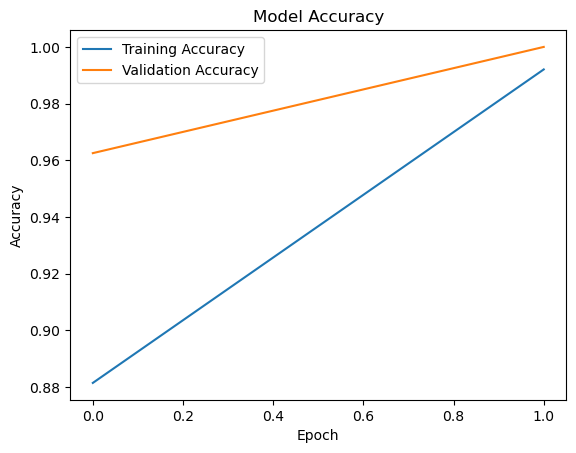

In [4]:
model=get_model()
model.summary()
early_stopping_callback = CustomCallback()
x_train_reshaped=[]
 
x_train_reshaped=tf.convert_to_tensor(x_train , dtype=tf.float32)

history=model.fit(x_train_reshaped, y_train, 
          validation_data=(x_val, y_val)
          ,epochs=15
        , batch_size=1,callbacks=[early_stopping_callback]) 
model.evaluate(x_test,y_test)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()


In [74]:
model.layers[0].weights

[<tf.Variable 'conv1d_19/kernel:0' shape=(1, 1, 1) dtype=float32, numpy=array([[[1.6947203]]], dtype=float32)>,
 <tf.Variable 'conv1d_19/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00122851], dtype=float32)>]

1/1 [==============================] - 0s 173ms/step
[[1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


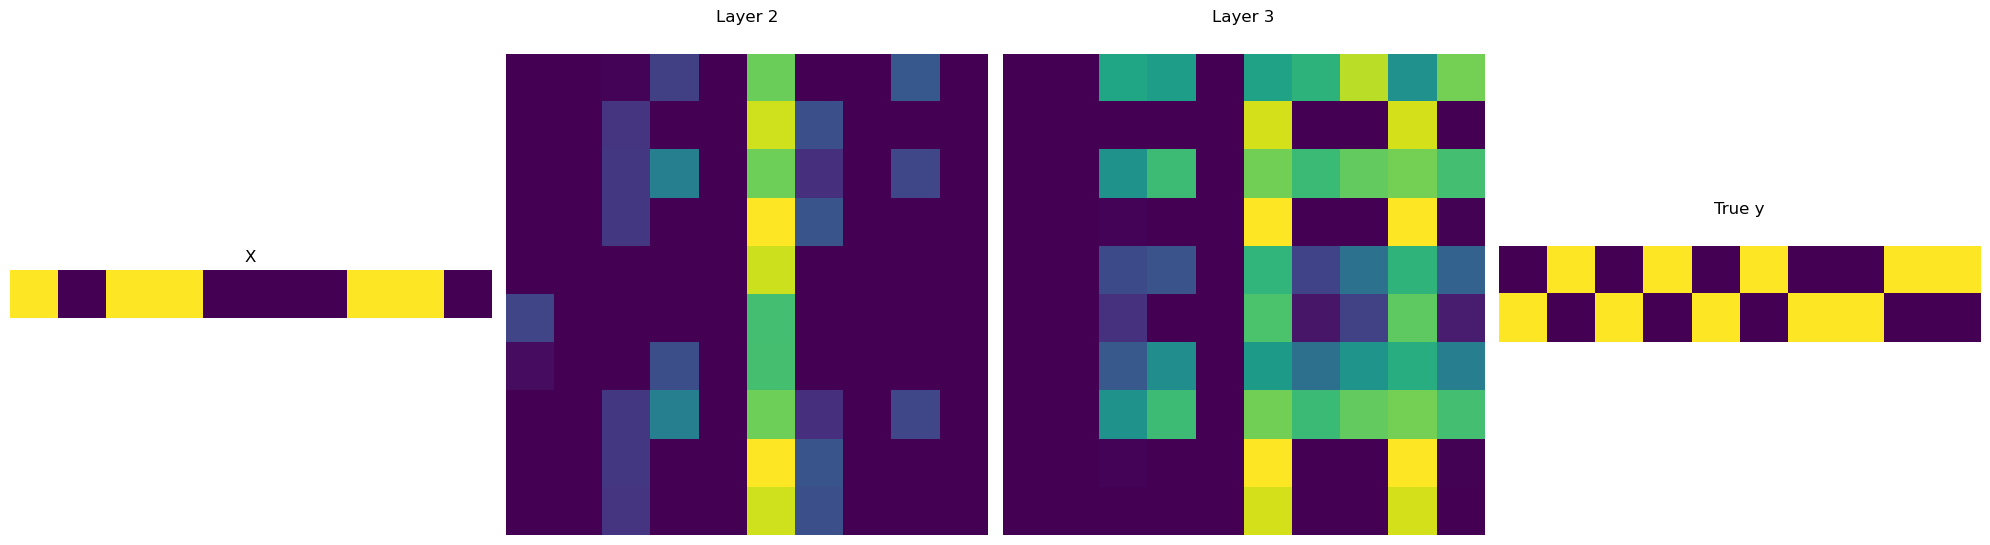

1/1 [==============================] - 0s 14ms/step
[[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


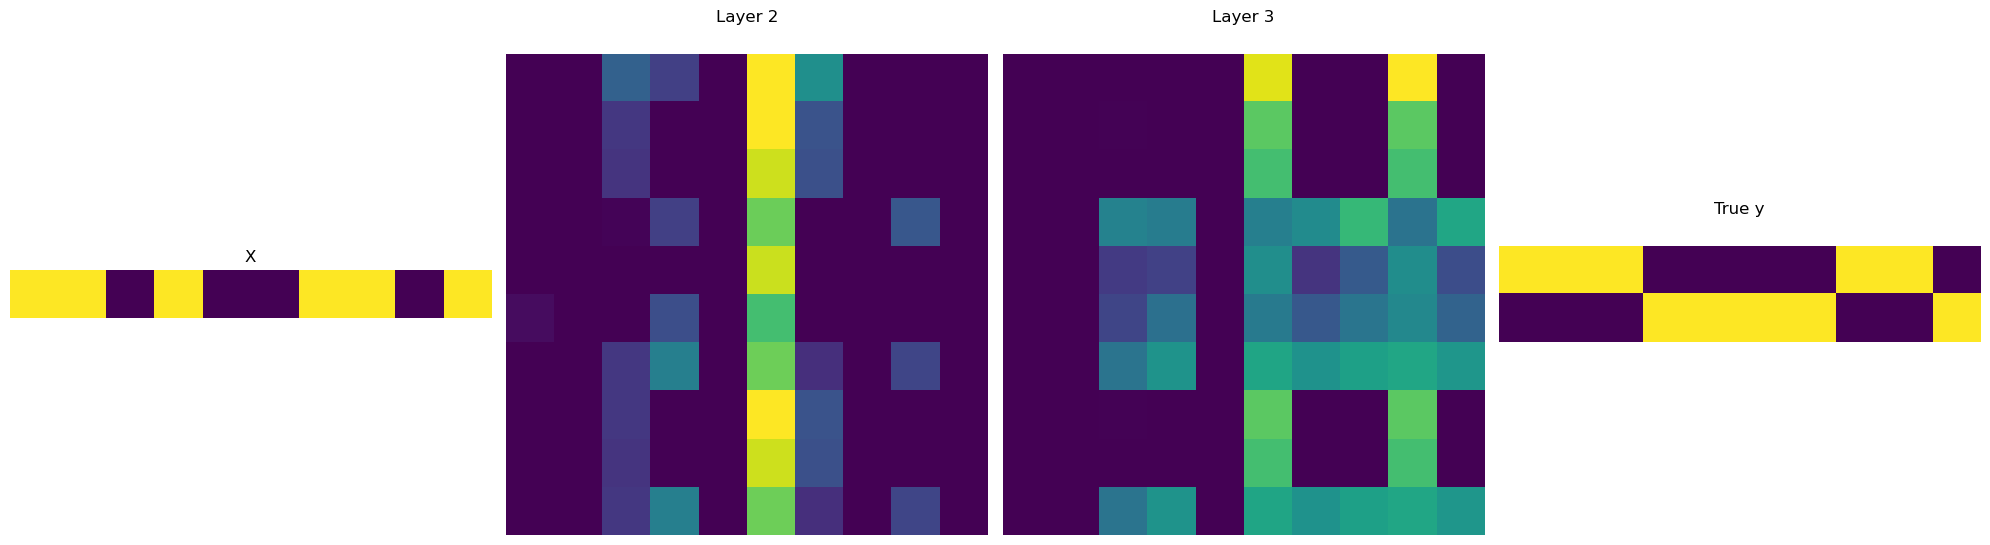

1/1 [==============================] - 0s 15ms/step
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


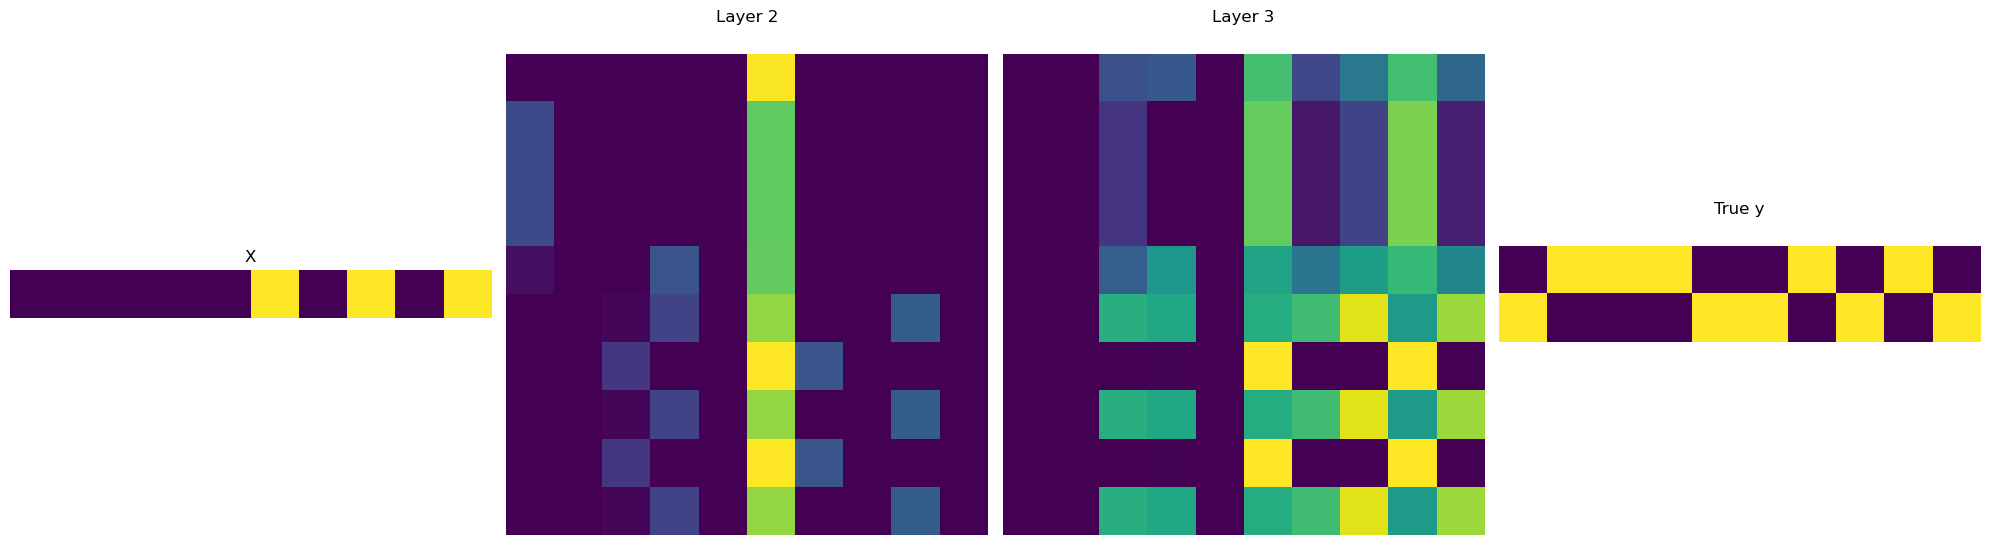

1/1 [==============================] - 0s 15ms/step
[[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


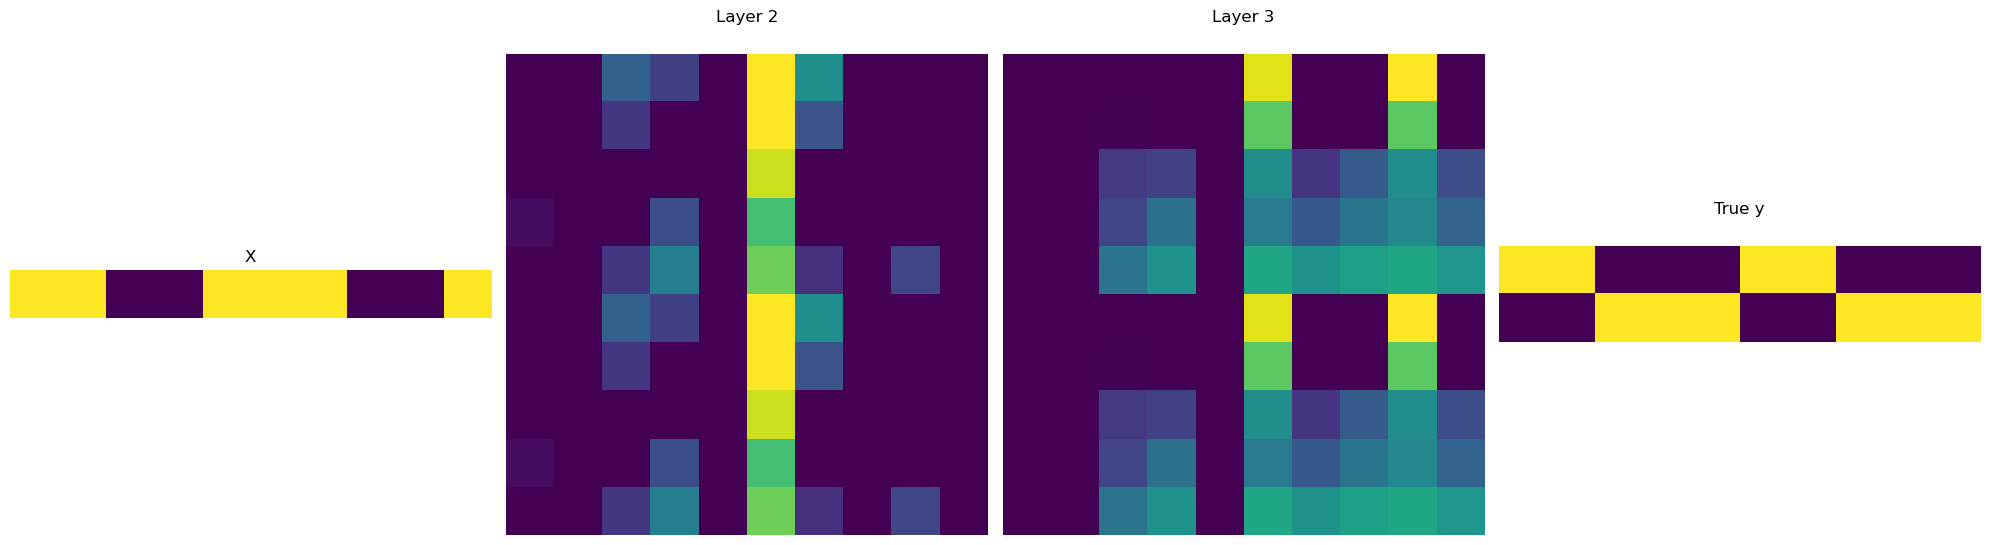

1/1 [==============================] - 0s 15ms/step
[[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


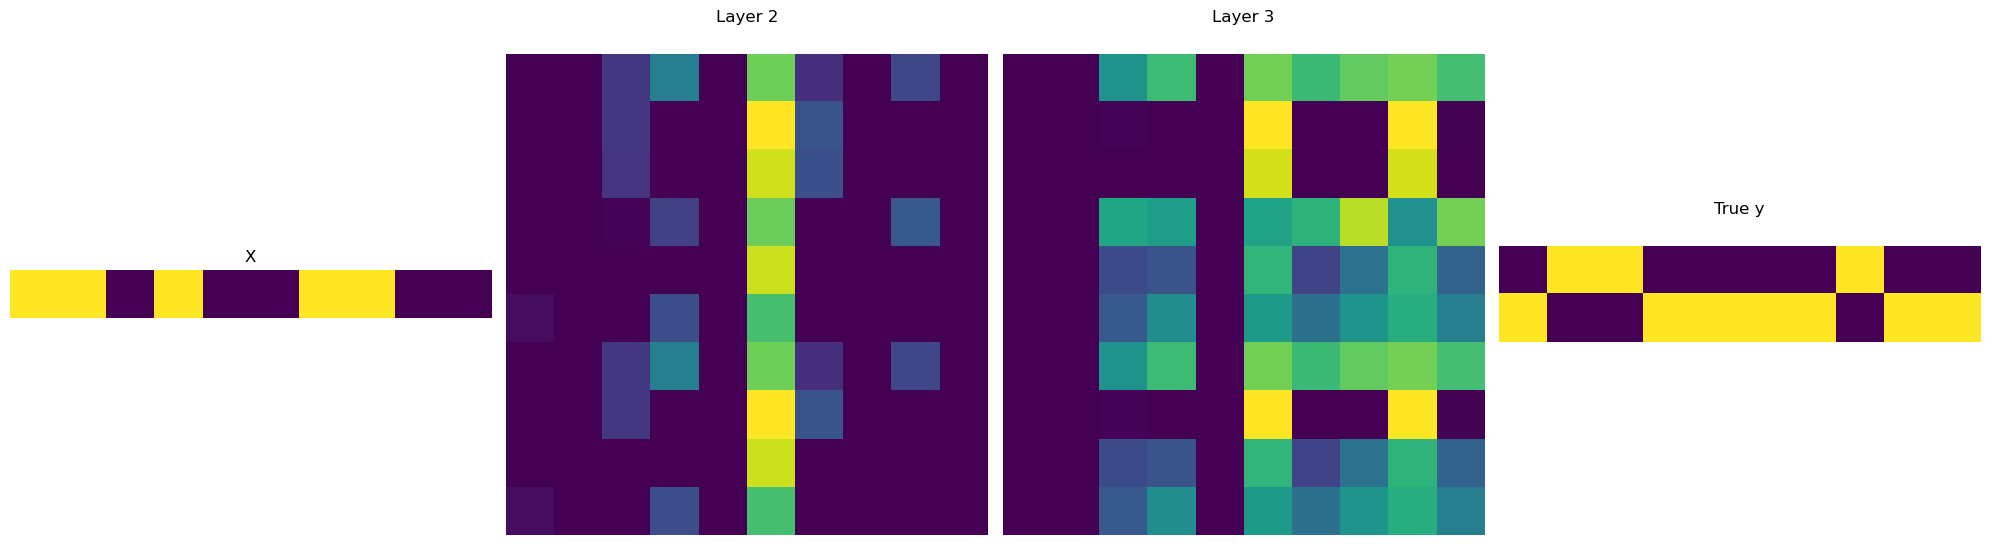

1/1 [==============================] - 0s 14ms/step
[[1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


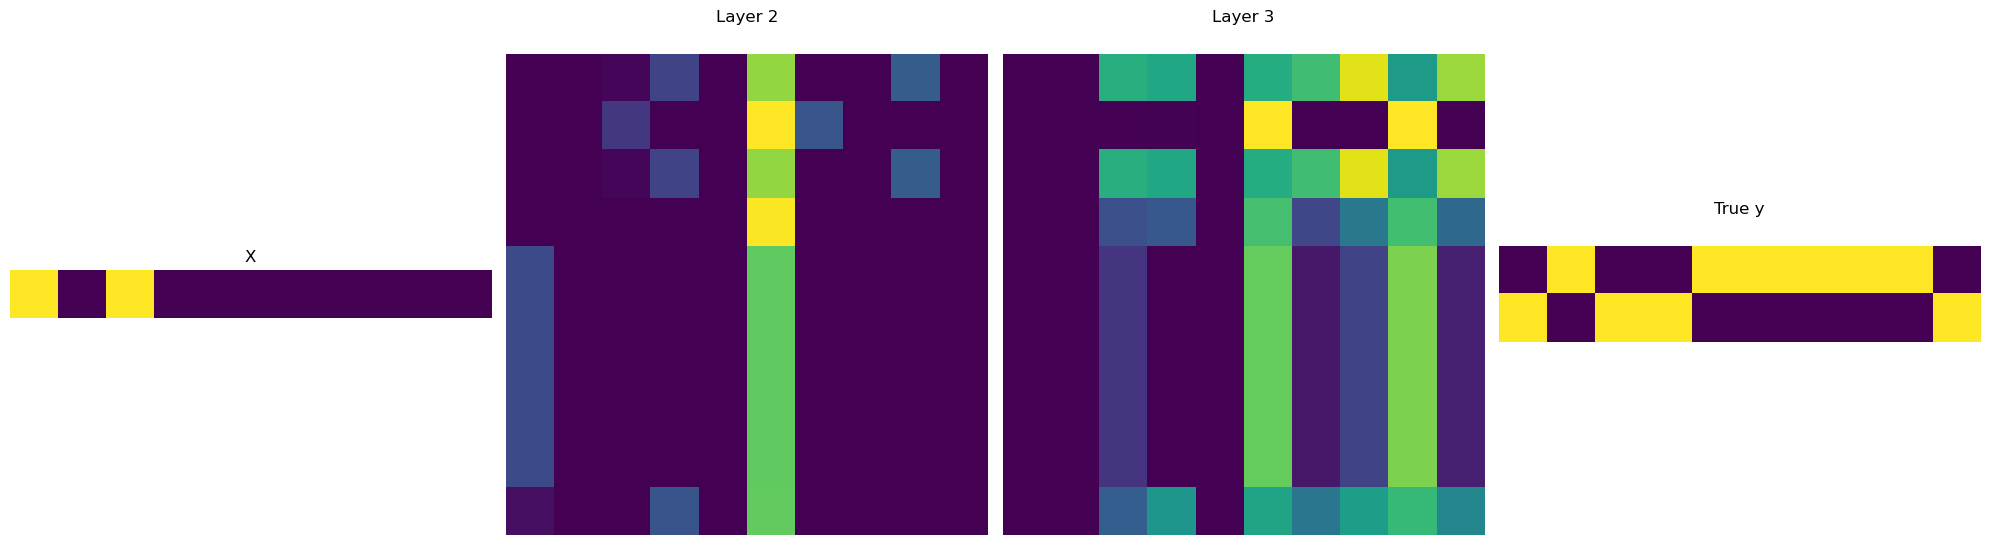

1/1 [==============================] - 0s 16ms/step
[[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


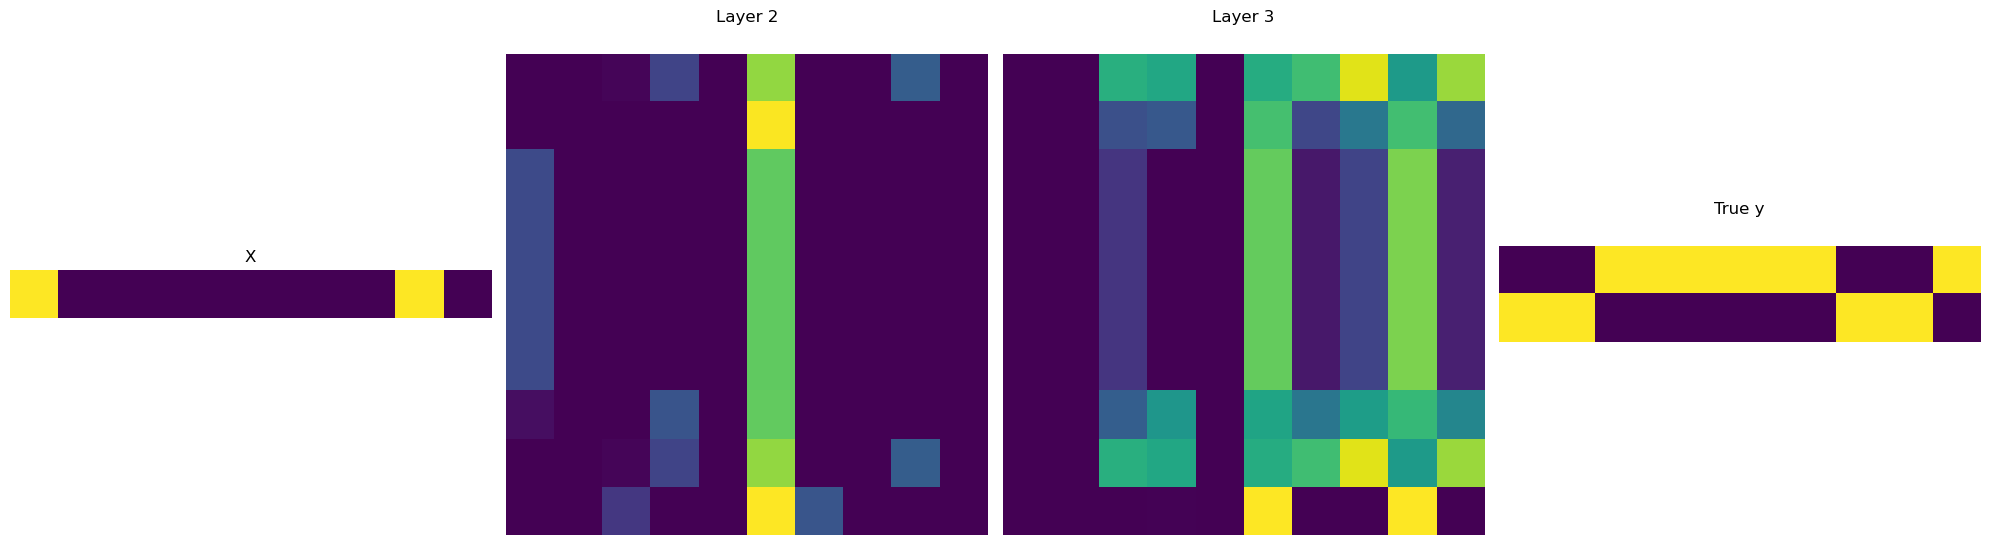

1/1 [==============================] - 0s 15ms/step
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


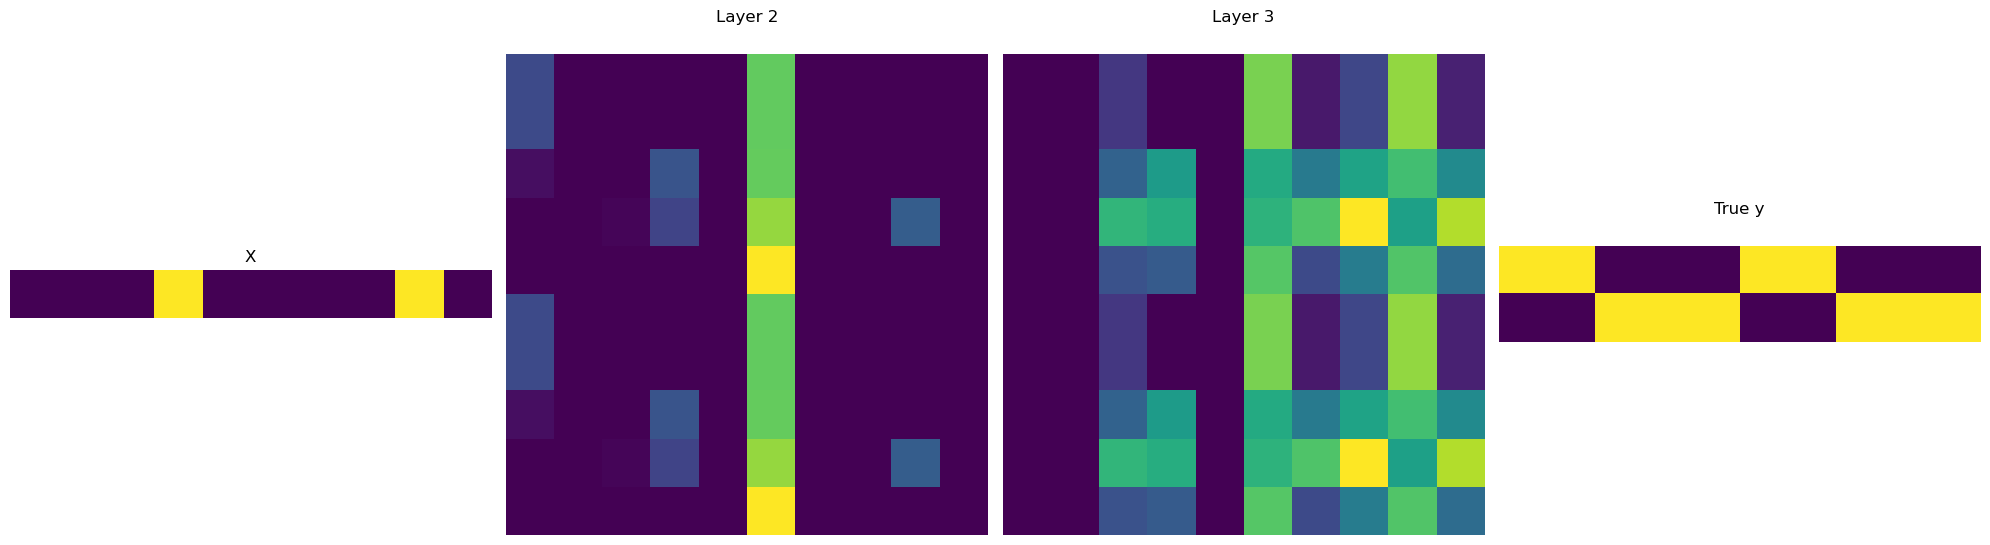

1/1 [==============================] - 0s 15ms/step
[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


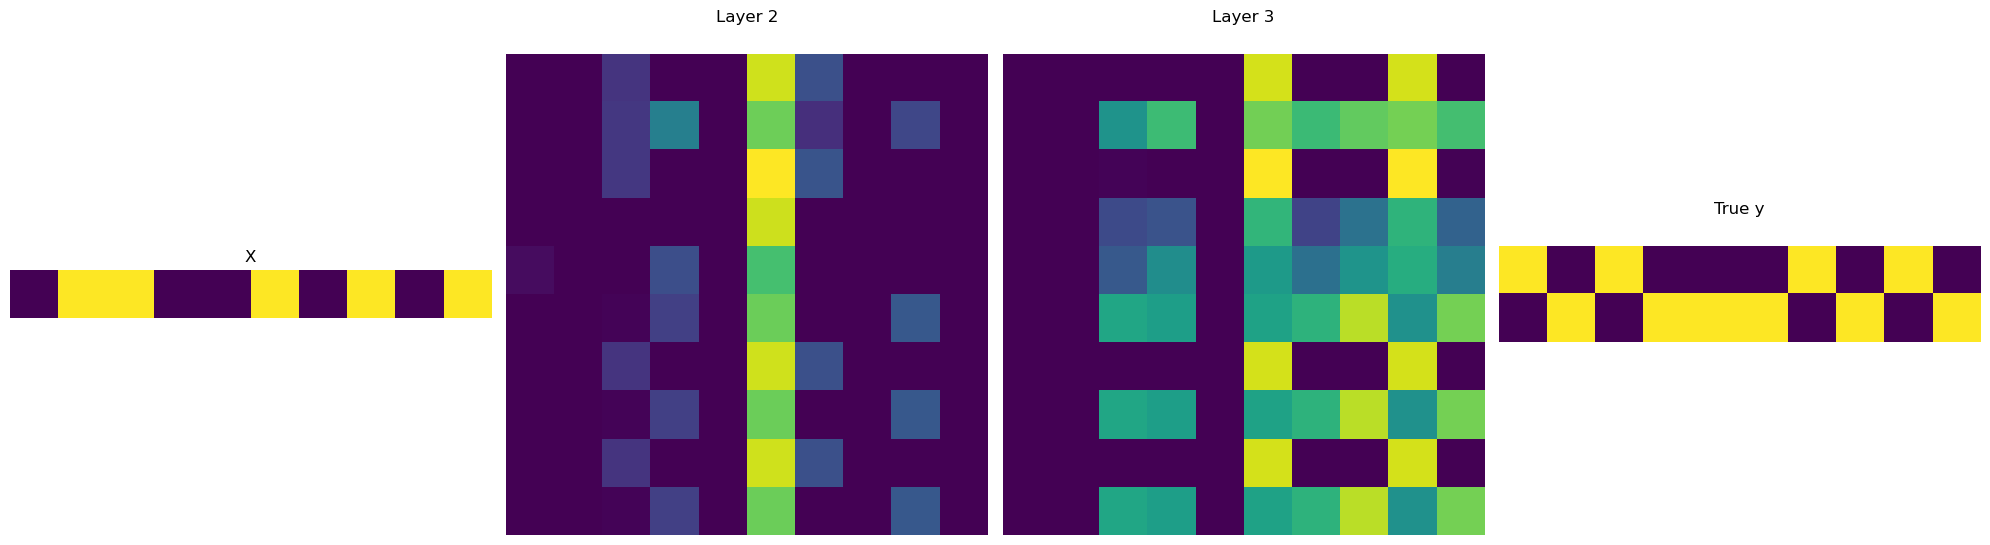

1/1 [==============================] - 0s 15ms/step
[[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


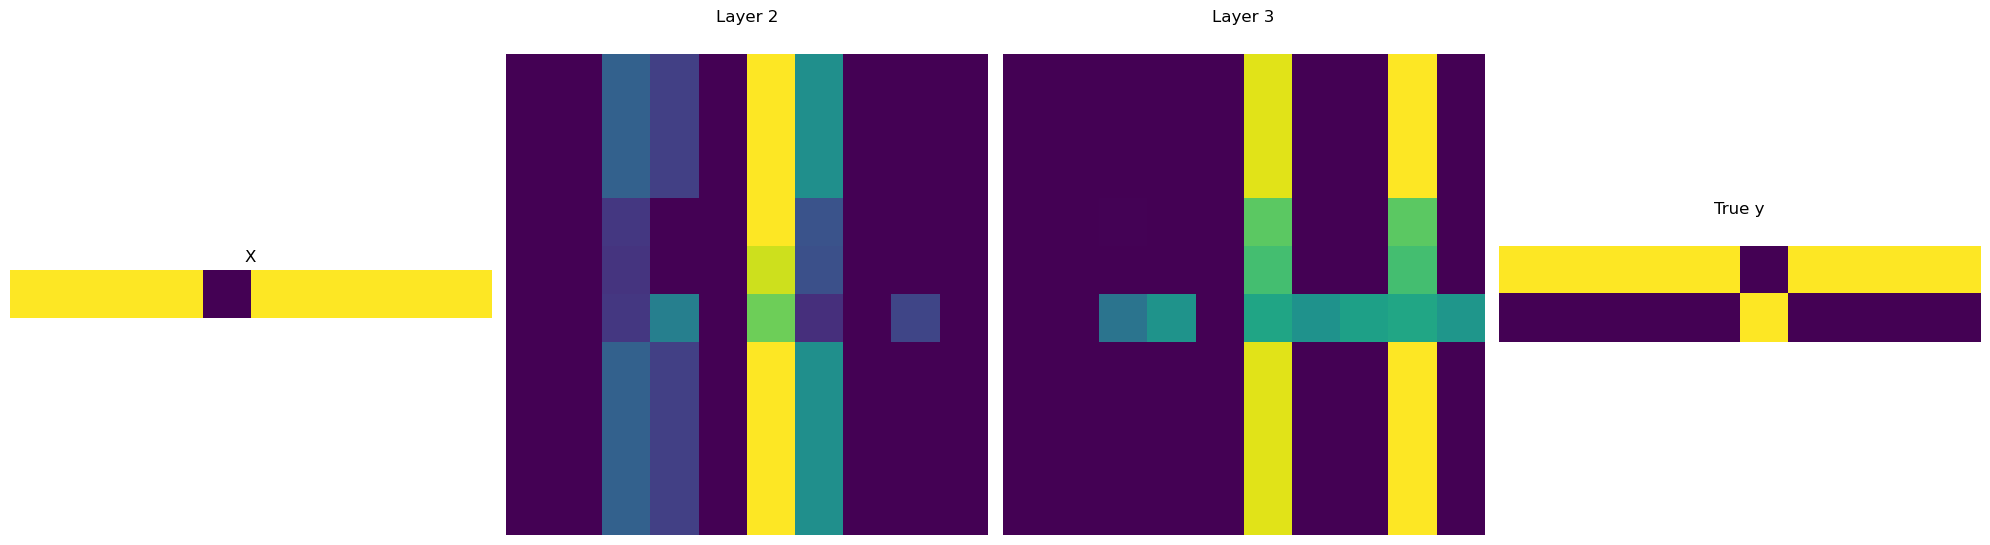

1/1 [==============================] - 0s 15ms/step
[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


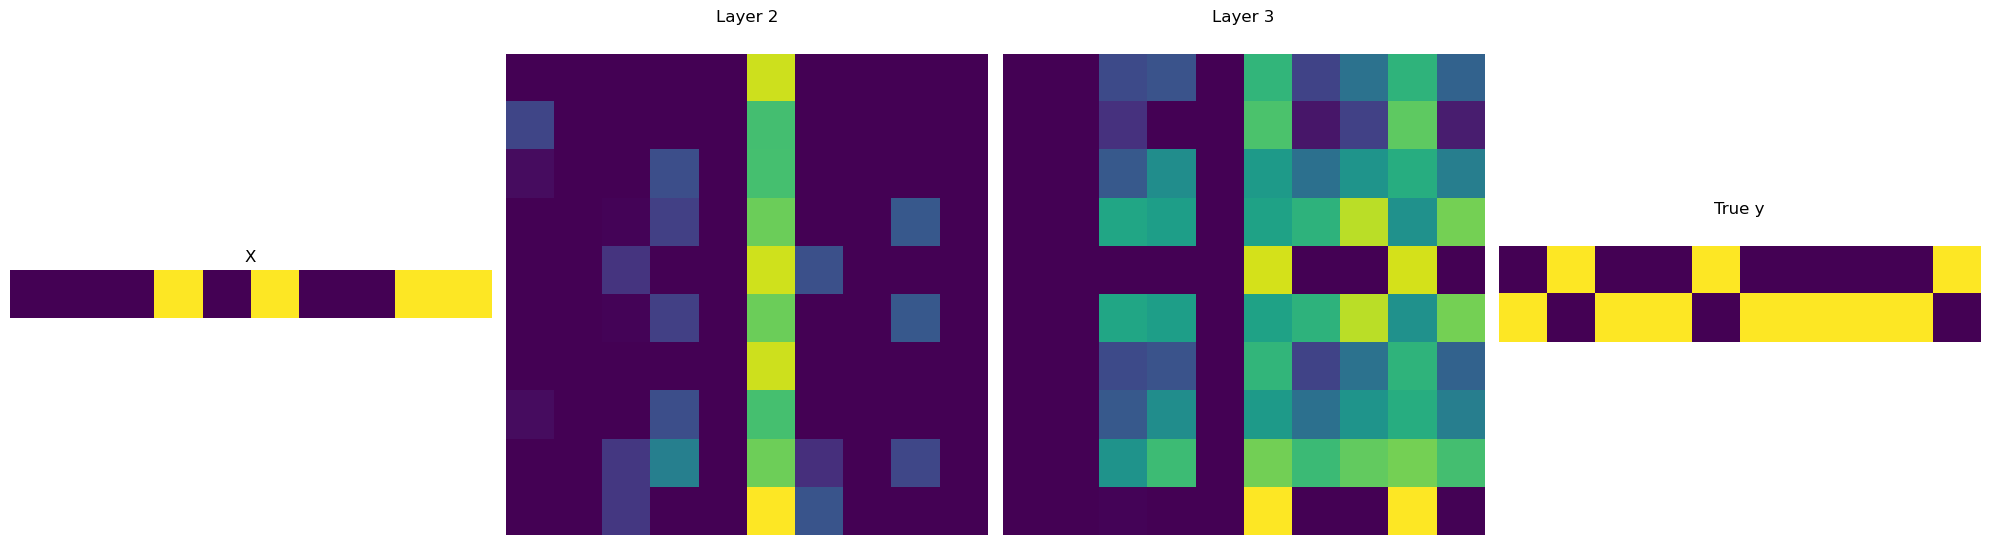

1/1 [==============================] - 0s 16ms/step
[[0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


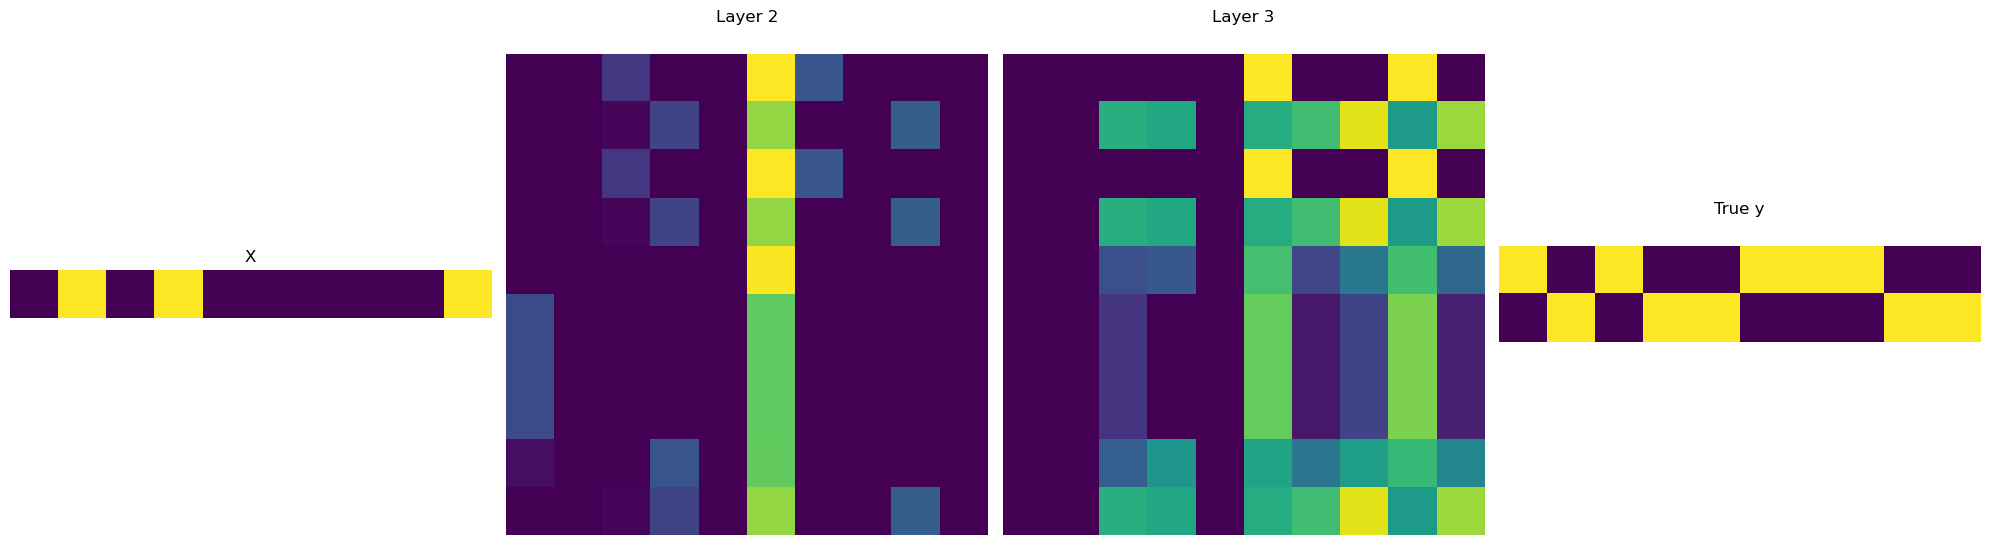

1/1 [==============================] - 0s 15ms/step
[[0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


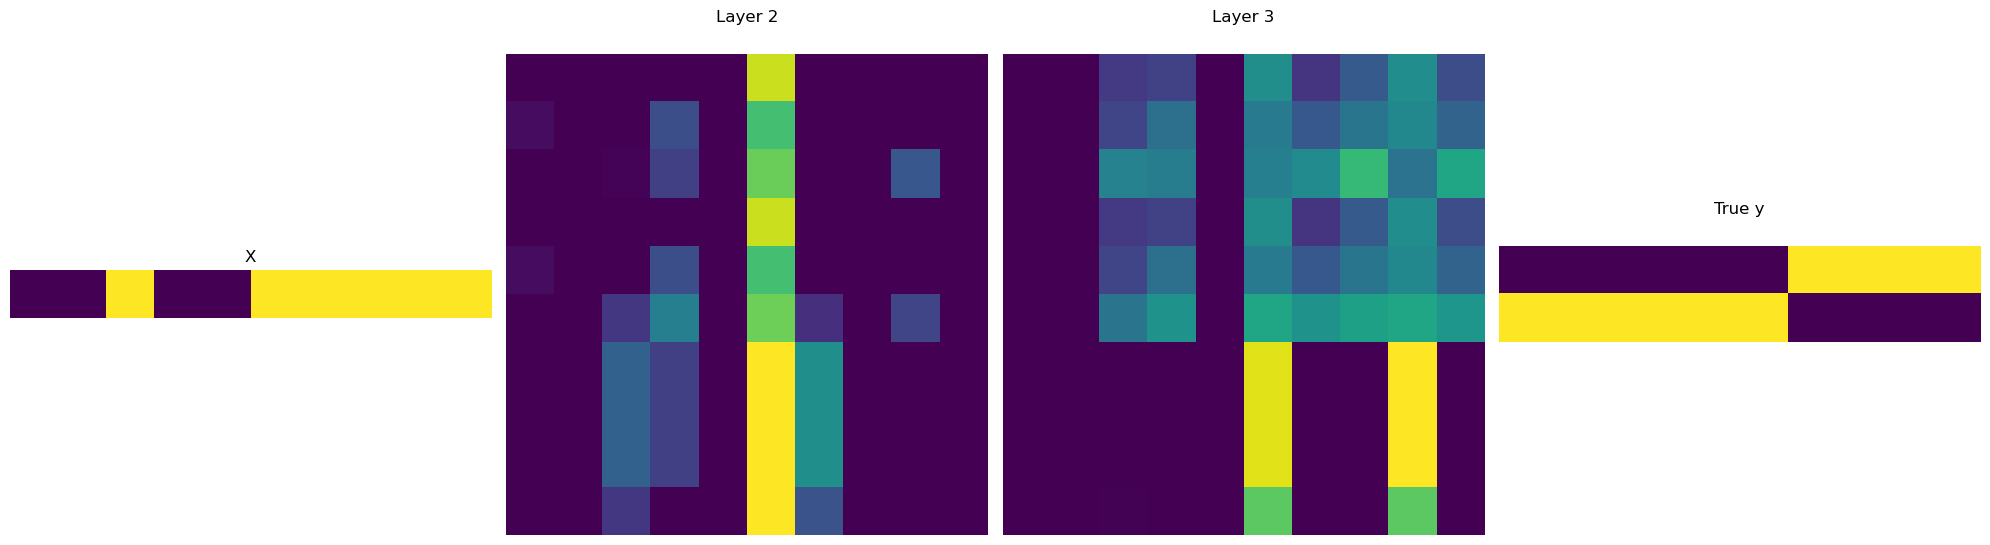

1/1 [==============================] - 0s 15ms/step
[[0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


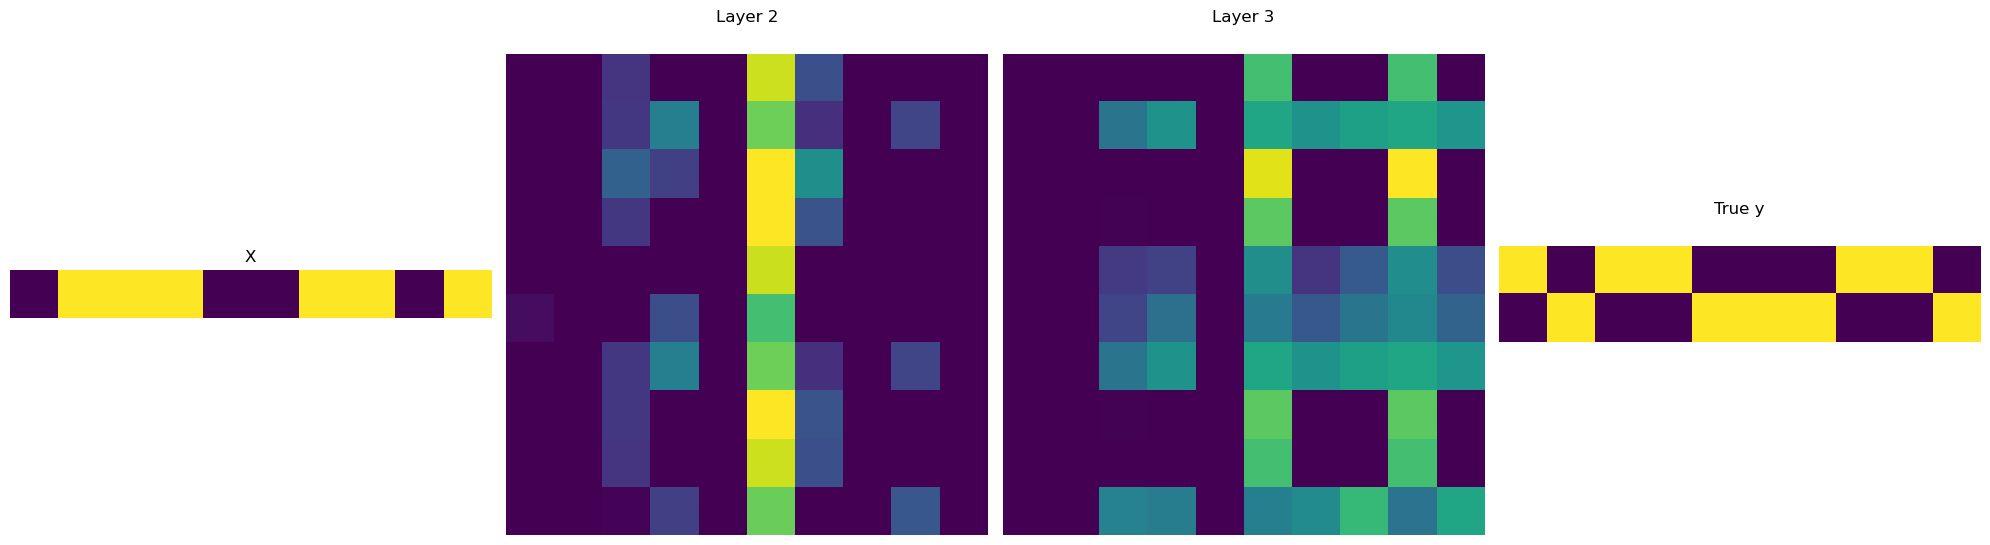

1/1 [==============================] - 0s 16ms/step
[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


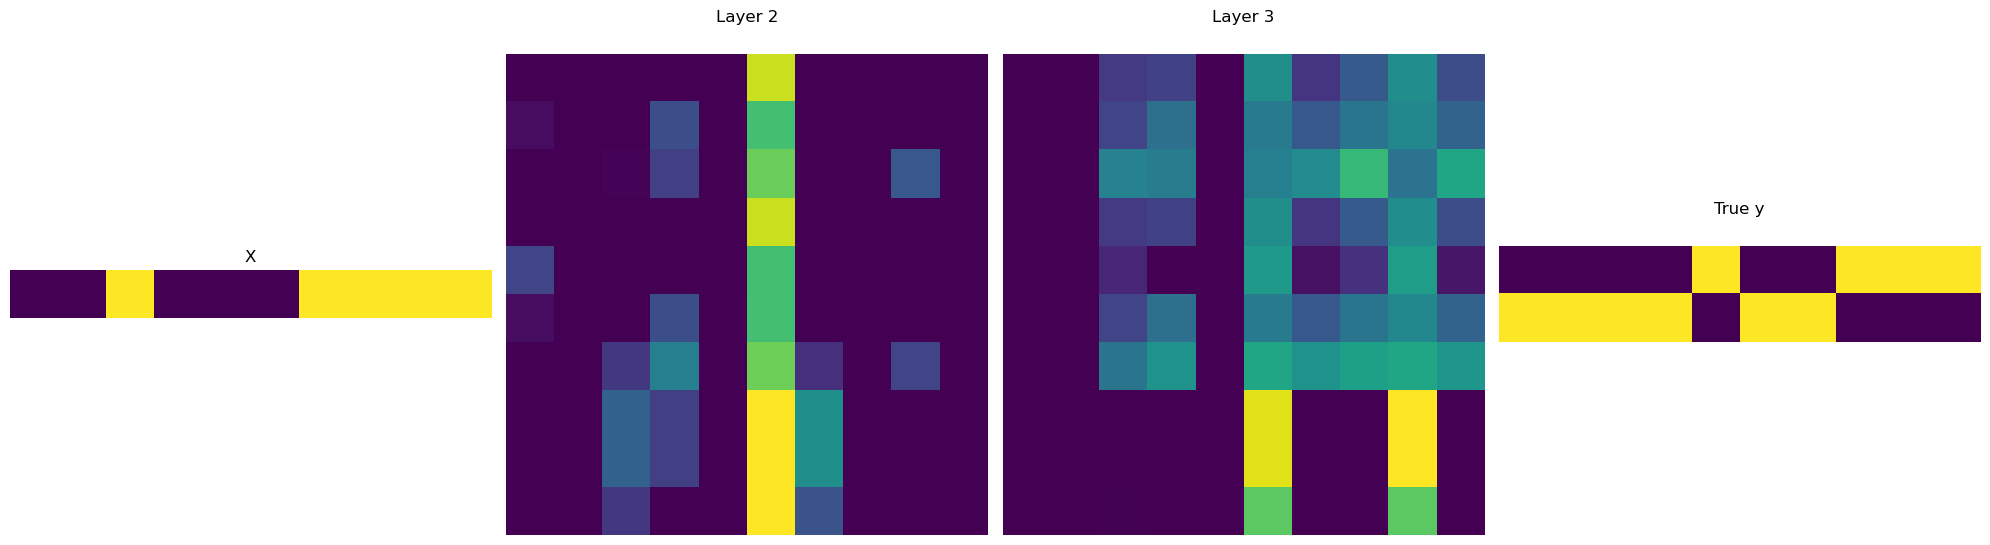

1/1 [==============================] - 0s 15ms/step
[[0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]], shape=(10, 2), dtype=float32)


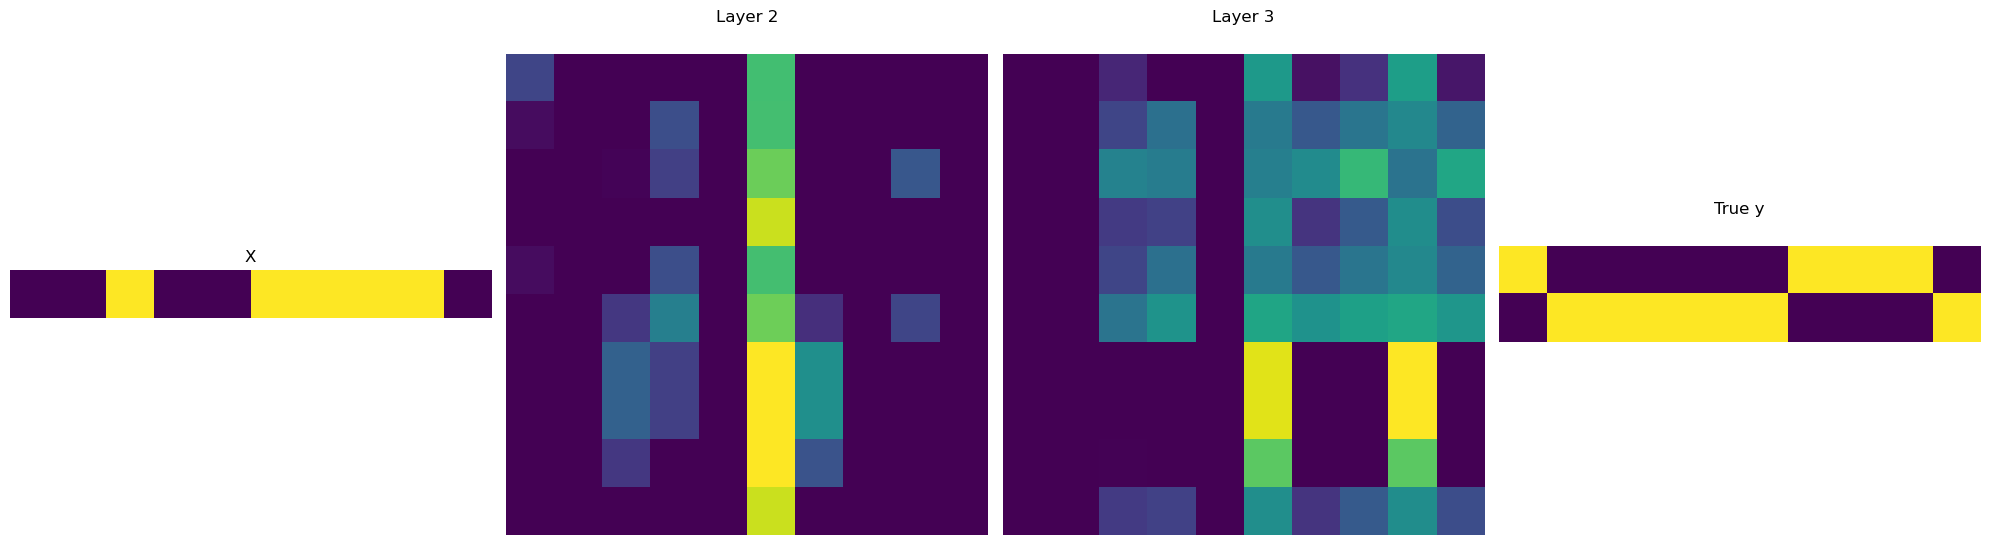

1/1 [==============================] - 0s 15ms/step
[[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(10, 2), dtype=float32)


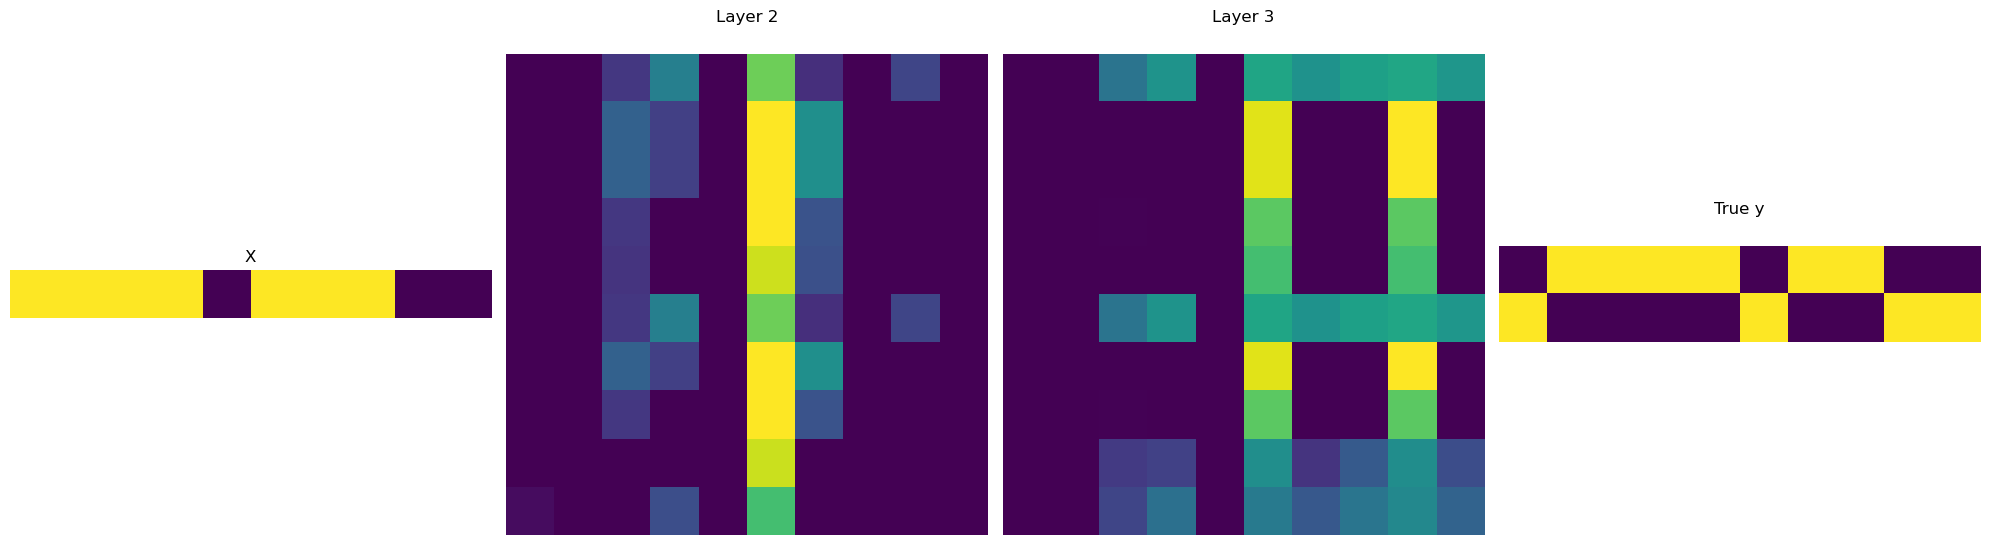

1/1 [==============================] - 0s 15ms/step
[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


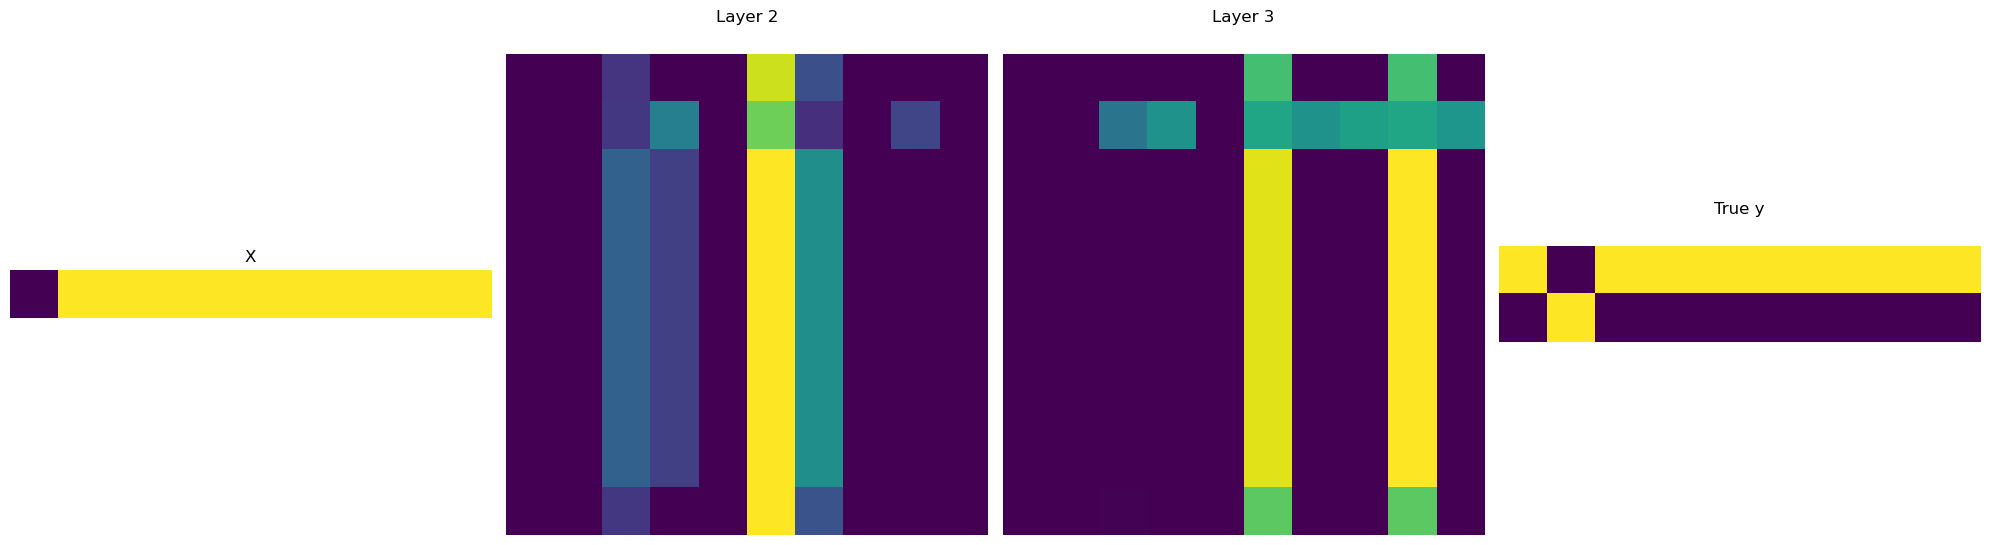

1/1 [==============================] - 0s 15ms/step
[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]
tf.Tensor(
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


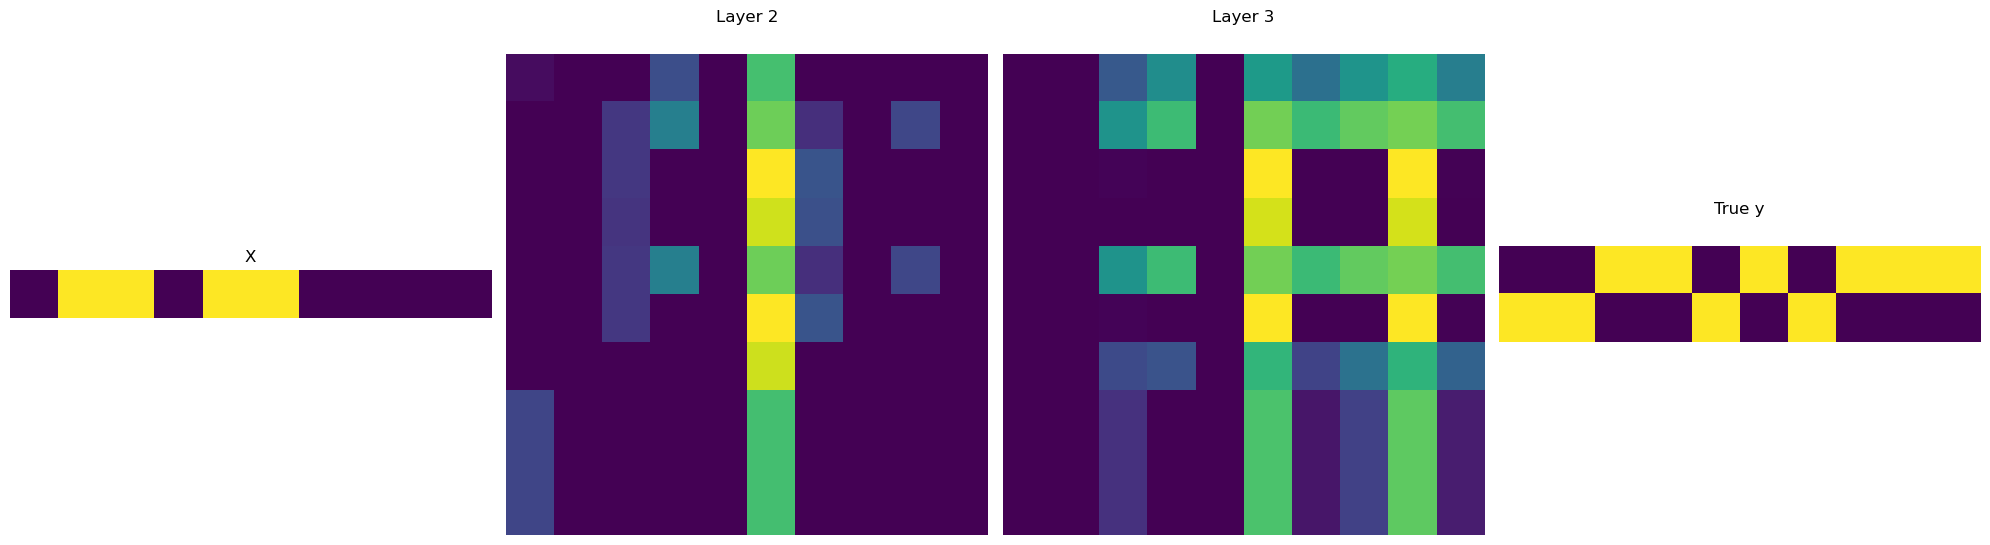

1/1 [==============================] - 0s 15ms/step
[[1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]]
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


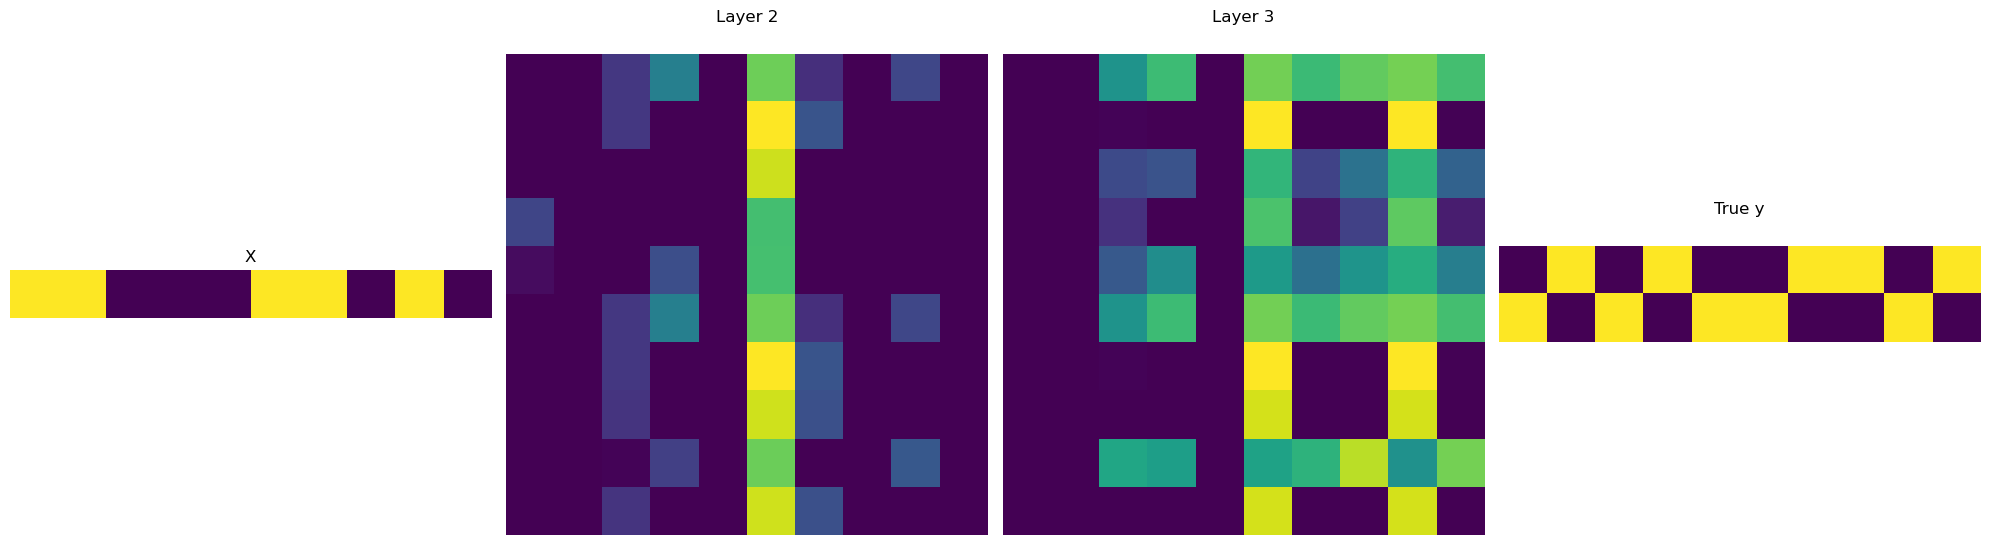

In [75]:
from tensorflow.keras.models import Model
 

conv_layer_outputs = [layer.output for layer in model.layers if "conv" in layer.name.lower()]
activation_model = Model(inputs=model.input, outputs=conv_layer_outputs)

for ind, x in enumerate(x_train[0:20]):
    x_to_visualize = np.expand_dims(x, axis=0)

    activations = activation_model.predict(x_to_visualize)
    model_output =model.predict(x_to_visualize)
    num_layers = len(activations)
    fig, axes = plt.subplots(1,4, figsize=(20, 20))

    axes[0].imshow(x_to_visualize[0, :].transpose(), cmap="viridis")
    axes[0].set_title("X")
    axes[0].axis("off")


    for i, activation in enumerate(activations[-2:]):
        ax = axes[i + 1]
        ax.matshow(activation[0, :, :], cmap="viridis")
        ax.set_title(f"Layer {num_layers - 1 + i}")
        ax.axis("off")
    
    print(x_train[ind])
    print(y_train[ind])
    axes[-1].matshow(np.array(y_train[ind]).transpose(), cmap="viridis")
    axes[-1].set_title("True y")
    axes[-1].axis("off")

    plt.tight_layout()

   # plt.savefig("Recurrentmem3activations" + str(ind) + ".png", dpi=300, bbox_inches="tight")
    plt.show()


In [7]:
def recover_rule(model, permutations):
    consistent=True
    
    neighborhoods = [seq for seq in itertools.product("01", repeat=3)]
    neighborhoods = np.squeeze(np.array([[int(bit) for bit in seq] for seq in neighborhoods]))
    mapping = {tuple(neighborhood): -1 for neighborhood in neighborhoods}
    occurence = {tuple(neighborhood): 0 for neighborhood in neighborhoods}
    print(mapping)
    predictions = model.predict(permutations)
    decoded_pred = np.argmax(predictions, axis=2)
    rule = {}
    for input, prediction in zip(permutations, decoded_pred):
        input=(np.squeeze(input))
        input_padded=np.insert(input,0,input[-1])
        input_padded=np.append(input_padded,input[0])
        for i in range(1,len(input_padded)-1):
            x_value=tuple(input_padded[i-1:i+2])
            y=prediction[i-1]
            if(mapping[(x_value)]==-1):
                mapping[(x_value)]=y
            if(mapping[(x_value)]!=y):
                consistent=False
                occurence[(x_value)]+=1
                mapping[(x_value)]+=y
                
    if consistent:
        print("Mapping was consistent.")
    else:
        print("Mapping was inconsistent, recoverd most likley result" )
        
        for key in mapping:
            if(mapping[key]>1):
                mapping[key]=round( mapping[key]/occurence[key])
    print(mapping)
    
recover_rule(model,x_test)    
ca.rule_sheet

{(0, 0, 0): -1, (0, 0, 1): -1, (0, 1, 0): -1, (0, 1, 1): -1, (1, 0, 0): -1, (1, 0, 1): -1, (1, 1, 0): -1, (1, 1, 1): -1}
4/4 [==============================] - 0s 1ms/step
Mapping was consistent.
{(0, 0, 0): 0, (0, 0, 1): 1, (0, 1, 0): 0, (0, 1, 1): 0, (1, 0, 0): 0, (1, 0, 1): 0, (1, 1, 0): 0, (1, 1, 1): 1}


[[[1, 1, 1],
  [1, 1, 0],
  [1, 0, 1],
  [1, 0, 0],
  [0, 1, 1],
  [0, 1, 0],
  [0, 0, 1],
  [0, 0, 0]],
 [[1], [0], [0], [0], [0], [0], [1], [0]]]

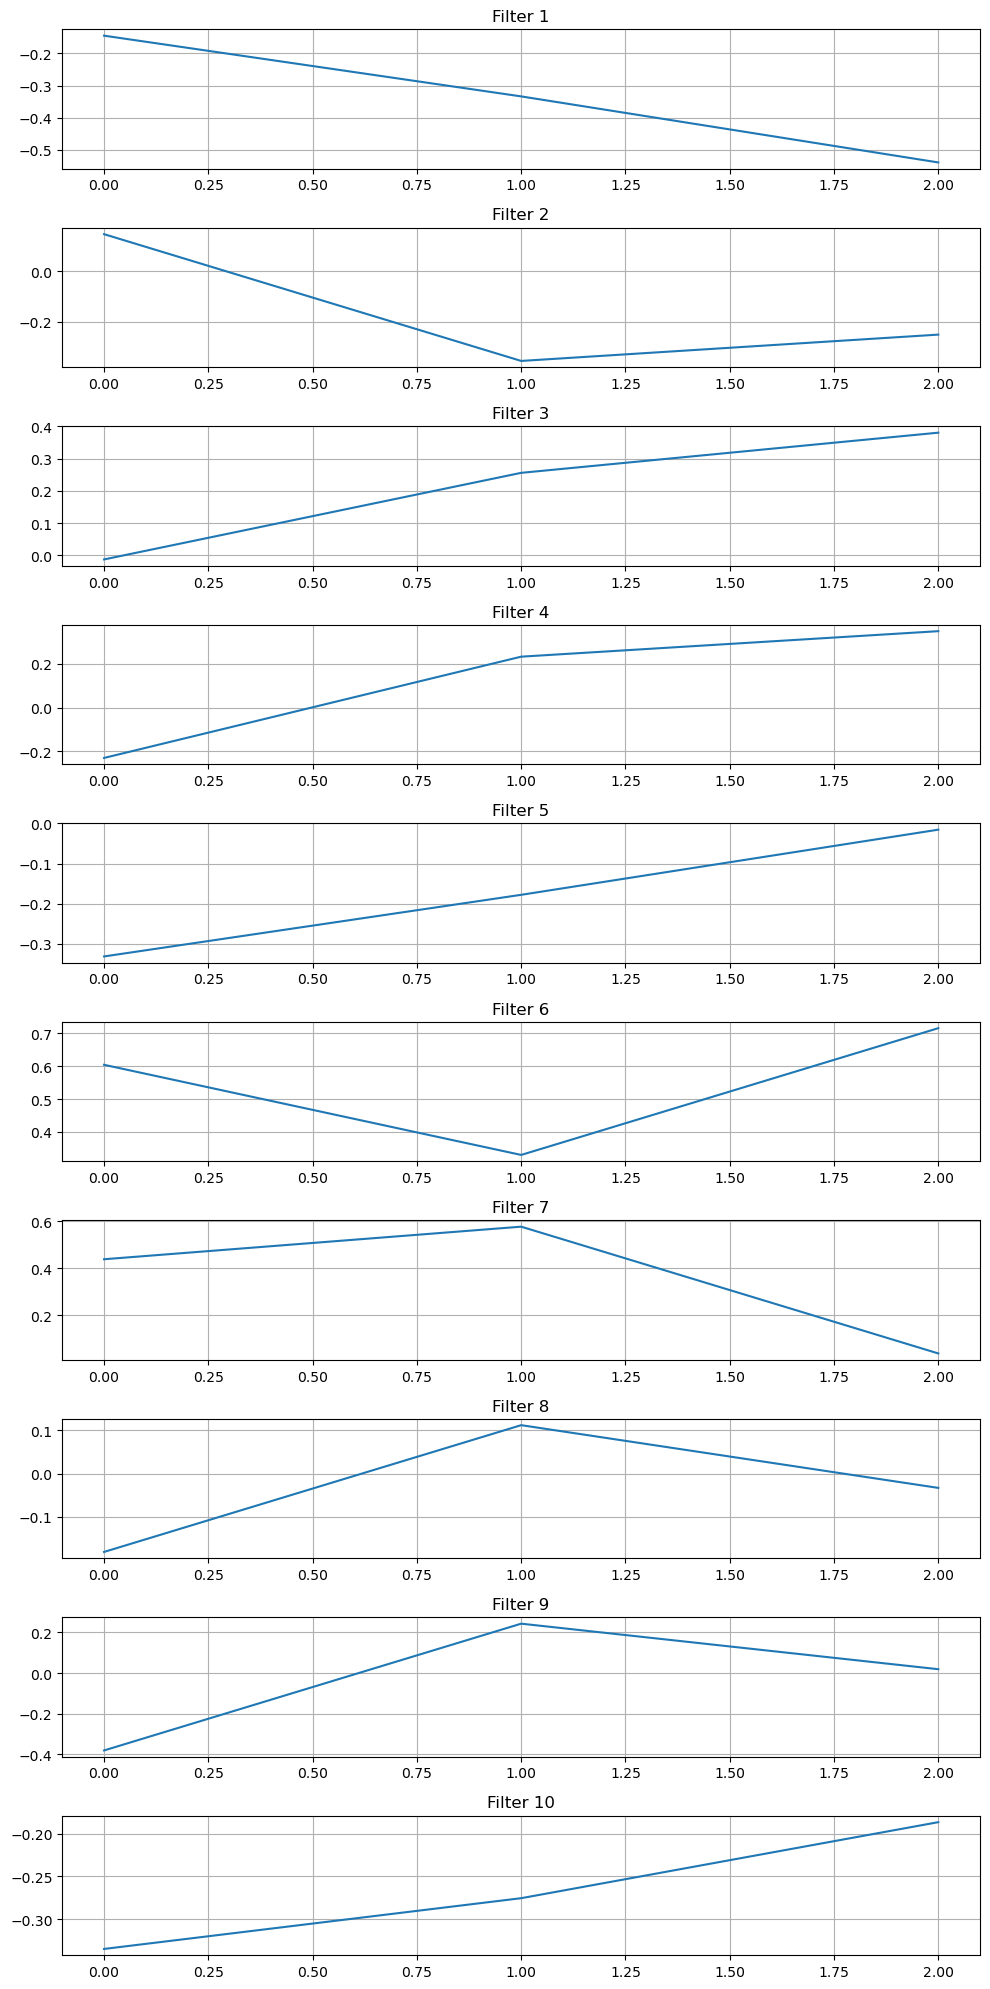

In [77]:

# Extract weights of the last Conv1D layer
last_conv_layer = model.layers[-3]  # This gets the Conv1D layer just before the last two Dense layers
weights_last_conv = last_conv_layer.get_weights()[0]  # [0] because it gets the kernel weights

num_filters = weights_last_conv.shape[-1]


fig, axes = plt.subplots(nrows=num_filters, figsize=(10, num_filters * 2))

for i in range(num_filters):
    axes[i].plot(weights_last_conv[:, 0, i])
    axes[i].set_title(f"Filter {i + 1}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# Visualize

# Demonstrate Correct ordering

In [76]:
data=x_sequence[0]
print(data)
print(" ")
print(data.reshape(-1,10,3))
print(np.transpose(data))

[[0 1 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 0 1 1 0]]
 
[[[0 1 0]
  [0 0 0]
  [0 0 1]
  [1 1 0]
  [0 0 0]
  [0 0 1]
  [1 0 0]
  [1 0 0]
  [0 0 0]
  [1 1 0]]]
[[0 1 0]
 [1 0 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]]


# Just The Memory

In [15]:
MEMORY_CONSTANT=3 
sequence_length=MEMORY_CONSTANT*2
 
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

ca.set_rule_number(38)

sequences= np.array(ca.generate_training_data_sequences(x_values,sequence_length=sequence_length))
np.random.shuffle(sequences)

y_sequence= []
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
for x in x_sequence:
    y_sequence.append(ca.mostFrequentPastStateBinary(x))
y_sequence=np.array(y_sequence)
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), 2))
 
x_train = x_sequence
 
split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
 
x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x_train_reshaped,Y_val_onehot)

num_filters = 1
kernel_size = MEMORY_CONSTANT
 
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,MEMORY_CONSTANT,1   )))  

model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                 kernel_initializer=tf.keras.initializers.ones(), 
                             trainable=True,use_bias=True,
                                 activation="relu"               ))

#model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
#                               kernel_initializer=tf.keras.initializers.Ones()))

model.add(tf.keras.layers.Reshape((gridsize,1)))
model.add(tf.keras.layers.Dense(units=2, activation="relu" ))
                           

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()

x_train_reshaped=tf.convert_to_tensor( np.array(x_train), dtype=tf.float32)
model.fit(x_train_reshaped, y_train, validation_data=(x_val, y_val), epochs=10
        , batch_size=1,callbacks=[early_stopping_callback])
 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 10, 1, 1)          4         
                                                                 
 reshape_9 (Reshape)         (None, 10, 1)             0         
                                                                 
 dense_8 (Dense)             (None, 10, 2)             4         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
768/768 [==============================] - 1s 1ms/step - loss: 0.7096 - accuracy: 0.6536 - val_loss: 0.6239 - val_accuracy: 0.8695
Epoch 2/10
768/768 [==============================] - 1s 1ms/step - loss: 0.6167 - accuracy: 0.8685 - val_loss: 0.6081 - val_accuracy: 0.8695
Epoch 3/10
768/768 [===================

In [16]:
model.weights

[<tf.Variable 'conv1d_9/kernel:0' shape=(3, 1, 1) dtype=float32, numpy=
 array([[[1.1016997]],
 
        [[1.1014575]],
 
        [[1.1006713]]], dtype=float32)>,
 <tf.Variable 'conv1d_9/bias:0' shape=(1,) dtype=float32, numpy=array([-0.7406291], dtype=float32)>,
 <tf.Variable 'dense_8/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[-0.6791405,  1.9517628]], dtype=float32)>,
 <tf.Variable 'dense_8/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.        , -0.70985687], dtype=float32)>]

In [11]:
histories=[]
skipped=[]
failed=[]
i=0

# learning mutiple rules

In [24]:
set_seed()
MEMORY_CONSTANT=1
kernel_size=MEMORY_CONSTANT
sequence_length=MEMORY_CONSTANT*2

num_filters=1
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

np.random.shuffle(x_values)

y_sequence= []
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
tries=0
 
while i< 256:
    print(i)
    
    ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)
    ca.set_rule_number(i)
    sequences= np.array(ca.generate_training_data_sequences(x_values,sequence_length=sequence_length))
    np.random.shuffle(sequences)

    x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
    y_sequence=sequences[:,MEMORY_CONSTANT*2]
    x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)

    Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
    x_train = x_sequence   
    y_train= Y_val_onehot

    y_train_full= Y_val_onehot



    split_ratio = 0.25
    x_train_reshaped=[]
    for data_point in x_train:
        x_train_reshaped.append(np.transpose(data_point))
    x_train_reshaped=np.array(x_train_reshaped)  

    x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x_train_reshaped,y_train_full)

    memory_horizon=MEMORY_CONSTANT# is equal to 1
    model =get_model()
    #model.summary()
    early_stopping_callback = CustomCallback()

  #  x_train=x_train.reshape(-1,10,3,1)
   # x_val=x_val.reshape(-1,10,3,1)
   # x_test=x_test.reshape(-1,10,3,1)
    history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10
            , batch_size=1,callbacks=[early_stopping_callback], verbose=True) 
    eval=model.evaluate(x_test,y_test,verbose=False)

    if(eval[1] <1 and max(history.history["val_accuracy"])<1 and max(history.history["accuracy"])<1):
        print(eval[1])
        tries=tries+1
        i=i-1
        
   
    else:
        histories.append(history)
        print(i)
        tries=0
    if tries >5:
        tries=0
        failed.append(i)
        i=i+1
        print("skipped")
    i=i+1


22
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_192 (Conv1D)         (None, 10, 1, 1)          8         
                                                                 
 reshape_64 (Reshape)        (None, 10, 1)             0         
                                                                 
 dense_128 (Dense)           (None, 10, 2)             4         
                                                                 
 wraparound1d_64 (Wraparound  (None, 12, 2)            0         
 1D)                                                             
                                                                 
 conv1d_193 (Conv1D)         (None, 10, 10)            70        
                                                                 
 conv1d_194 (Conv1D)         (None, 10, 10)            110       
                                                  

768/768 [==============================] - 2s 2ms/step - loss: 0.1624 - accuracy: 0.9389 - val_loss: 0.1566 - val_accuracy: 0.9414
Epoch 16/35
768/768 [==============================] - 2s 2ms/step - loss: 0.1575 - accuracy: 0.9421 - val_loss: 0.1597 - val_accuracy: 0.9297
Epoch 17/35
768/768 [==============================] - 2s 2ms/step - loss: 0.1534 - accuracy: 0.9448 - val_loss: 0.1467 - val_accuracy: 0.9508
Epoch 18/35
768/768 [==============================] - 2s 2ms/step - loss: 0.1459 - accuracy: 0.9469 - val_loss: 0.1415 - val_accuracy: 0.9508
Epoch 19/35
768/768 [==============================] - 2s 2ms/step - loss: 0.1404 - accuracy: 0.9516 - val_loss: 0.1362 - val_accuracy: 0.9508
Epoch 20/35
768/768 [==============================] - 2s 2ms/step - loss: 0.1358 - accuracy: 0.9517 - val_loss: 0.1289 - val_accuracy: 0.9539
Epoch 21/35
768/768 [==============================] - 2s 2ms/step - loss: 0.1312 - accuracy: 0.9543 - val_loss: 0.1331 - val_accuracy: 0.9500
Epoch 22/35

In [21]:
len(histories)

23

In [57]:
file = open('hist1','w')
for item in histories:
	file.write(str(item.history["accuracy"])+", "+ str(item.history["val_accuracy"])+"\n")
file.close()

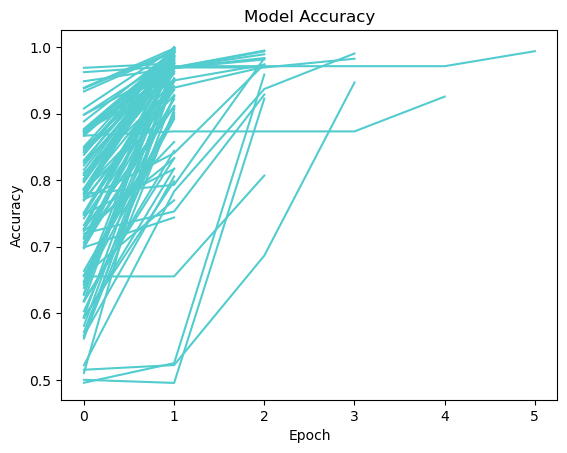

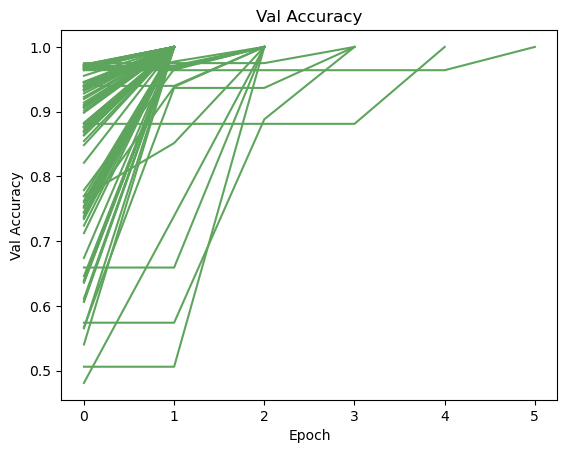

In [12]:
import matplotlib.pyplot as plt

# Plotting model accuracies
for history in histories:
    if max(history.history["accuracy"]):
        plt.plot(history.history["accuracy"], color="#52ccce")

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("Accuracy2 mem3")  
plt.show()  

# Plotting validation accuracies
for history in histories:
    if max(history.history["val_accuracy"]) >= 0.96:
        plt.plot(history.history["val_accuracy"], color="#5DA55c")

plt.title("Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.savefig("Val2 Accuracy mem3")  
plt.show()  


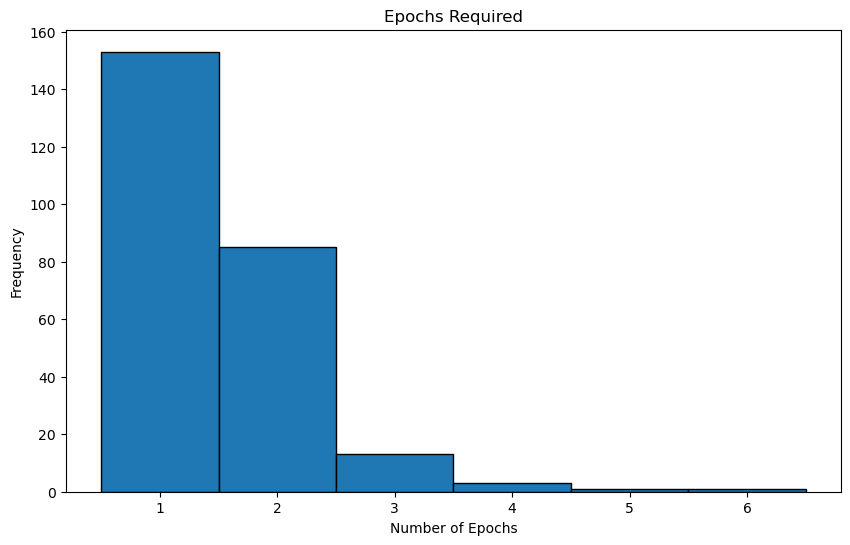

In [13]:
# Extract the number of epochs from each history object
epochs_required = [len(history.history['loss']) for history in histories]

# Now we will plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(epochs_required, bins=range(1, max(epochs_required) + 2), edgecolor='black', align='left')
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.title('Epochs Required')
plt.xticks(range(1, max(epochs_required) + 1))
plt.savefig("epochs_count_per_training_session.png")
plt.show()

# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

validation_accuracies = []
test_accuracies = []

for rule_number in range(256):
    print(rule_number)
    ca.set_rule_number(rule_number)
    sequences = np.array(ca.generate_training_data_sequences(x_values, sequence_length=6))
    np.random.shuffle(sequences)

    x_sequence = sequences[:, 3:3*2, :]
    y_sequence = sequences[:, 3*2, :]

    x_train, x_temp, y_train, y_temp = train_test_split(x_sequence, y_sequence, test_size=0.4, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

    x_train_flat = x_train.reshape(-1, 30)
    x_val_flat = x_val.reshape(-1, 30)
    x_test_flat = x_test.reshape(-1, 30)

    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(x_train_flat, y_train)

    best_tree = grid_search.best_estimator_
    predictions_val = best_tree.predict(x_val_flat)
    accuracy_val = accuracy_score(y_val, predictions_val)
    validation_accuracies.append(accuracy_val)

    predictions_test = best_tree.predict(x_test_flat)
    accuracy_test = accuracy_score(y_test, predictions_test)
    test_accuracies.append(accuracy_test)



0
Fitting 5 folds for each of 90 candidates, totalling 450 fits
1
Fitting 5 folds for each of 90 candidates, totalling 450 fits
2
Fitting 5 folds for each of 90 candidates, totalling 450 fits
3
Fitting 5 folds for each of 90 candidates, totalling 450 fits
4
Fitting 5 folds for each of 90 candidates, totalling 450 fits
5
Fitting 5 folds for each of 90 candidates, totalling 450 fits
6
Fitting 5 folds for each of 90 candidates, totalling 450 fits
7
Fitting 5 folds for each of 90 candidates, totalling 450 fits
8
Fitting 5 folds for each of 90 candidates, totalling 450 fits
9
Fitting 5 folds for each of 90 candidates, totalling 450 fits
10
Fitting 5 folds for each of 90 candidates, totalling 450 fits
11
Fitting 5 folds for each of 90 candidates, totalling 450 fits
12
Fitting 5 folds for each of 90 candidates, totalling 450 fits
13
Fitting 5 folds for each of 90 candidates, totalling 450 fits
14
Fitting 5 folds for each of 90 candidates, totalling 450 fits
15
Fitting 5 folds for each of 90 c

126
Fitting 5 folds for each of 90 candidates, totalling 450 fits
127
Fitting 5 folds for each of 90 candidates, totalling 450 fits
128
Fitting 5 folds for each of 90 candidates, totalling 450 fits
129
Fitting 5 folds for each of 90 candidates, totalling 450 fits
130
Fitting 5 folds for each of 90 candidates, totalling 450 fits
131
Fitting 5 folds for each of 90 candidates, totalling 450 fits
132
Fitting 5 folds for each of 90 candidates, totalling 450 fits
133
Fitting 5 folds for each of 90 candidates, totalling 450 fits
134
Fitting 5 folds for each of 90 candidates, totalling 450 fits
135
Fitting 5 folds for each of 90 candidates, totalling 450 fits
136
Fitting 5 folds for each of 90 candidates, totalling 450 fits
137
Fitting 5 folds for each of 90 candidates, totalling 450 fits
138
Fitting 5 folds for each of 90 candidates, totalling 450 fits
139
Fitting 5 folds for each of 90 candidates, totalling 450 fits
140
Fitting 5 folds for each of 90 candidates, totalling 450 fits
141
Fittin

251
Fitting 5 folds for each of 90 candidates, totalling 450 fits
252
Fitting 5 folds for each of 90 candidates, totalling 450 fits
253
Fitting 5 folds for each of 90 candidates, totalling 450 fits
254
Fitting 5 folds for each of 90 candidates, totalling 450 fits
255
Fitting 5 folds for each of 90 candidates, totalling 450 fits


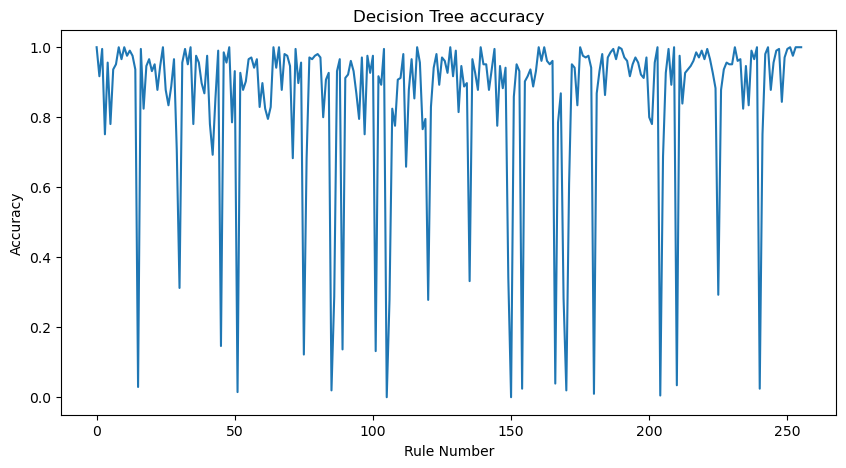

0.8490091463414638


In [28]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Decision Tree accuracy')
plt.xlabel('Rule Number')
plt.ylabel('Accuracy')
plt.show()
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(average_test_accuracy)


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [5, 10,20], 
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

validation_accuracies_forest = []
test_accuracies_forest = []

for rule_number in range(0,256):
    print(f"Processing rule number: {rule_number}")
    ca.set_rule_number(rule_number)
    sequences = np.array(ca.generate_training_data_sequences(x_values, sequence_length=6))
    np.random.shuffle(sequences)

    x_sequence = sequences[:, 3:3*2, :]
    y_sequence = sequences[:, 3*2, :]

    x_train, x_temp, y_train, y_temp = train_test_split(x_sequence, y_sequence, test_size=0.4, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

    x_train_flat = x_train.reshape(-1, 30)
    x_val_flat = x_val.reshape(-1, 30)
    x_test_flat = x_test.reshape(-1, 30)

    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(x_train_flat, y_train)

    best_forest = grid_search.best_estimator_
    predictions_val = best_forest.predict(x_val_flat)
    accuracy_val = accuracy_score(y_val, predictions_val)
    validation_accuracies_forest.append(accuracy_val)

    predictions_test = best_forest.predict(x_test_flat)
    accuracy_test = accuracy_score(y_test, predictions_test)
    test_accuracies_forest.append(accuracy_test)

 

Processing rule number: 0
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 1
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 2
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 3
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 4
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 5
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 6
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 7
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 8
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 9
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 10
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processin

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 91
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 92
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 93
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 94
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 95
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 96
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 97
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 98
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 99
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 100
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 1

Processing rule number: 180
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 181
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 182
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 183
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 184
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 185
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 186
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 187
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 188
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 189
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Processing rule number: 190
Fitting 5 folds for each of 270 candidates, totallin

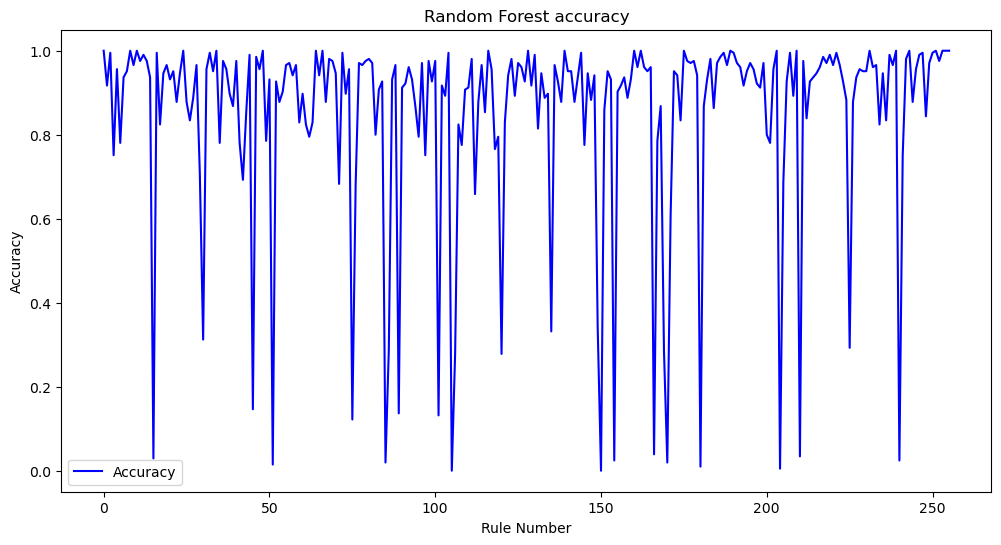

In [31]:
rule_numbers = list(range(256))

plt.figure(figsize=(12, 6))
plt.plot(rule_numbers, test_accuracies, label='Accuracy', color='blue')

plt.title('Random Forest accuracy')
plt.xlabel('Rule Number')
plt.ylabel('Accuracy')
plt.legend()

# Showing the plot
plt.show()

In [25]:
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(average_test_accuracy)


0.9311547256097569


# Effects of data set size

In [43]:


callback=CustomCallbackAcc()
def train_and_evaluate(x_train, y_train, x_test, y_test, train_percentage):
 
    num_train = int(len(x_train) * train_percentage / 100)
    x_train_subset = x_train[:num_train]
    y_train_subset = y_train[:num_train]
    print(x_train_subset.shape)
    model = get_model()
    history=model.fit(x_train_subset, y_train_subset 
      
          ,epochs=30, batch_size=1,callbacks=[callback]) 
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

 
#percentages = [20, 15,10,8]
avg_accuracies = []
percentages = [ 20, 15,10,8,5,3,2,1]
 
for p in percentages:
    accs=[]

    for i in range(0,5):
        
        acc = train_and_evaluate(x_train, y_train, x_test, y_test, p)
        accs.append(acc)
    avg_accuracies.append(sum(accs)/len(accs))
    print(p) 


plt.plot(percentages, avg_accuracies, marker='o')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Accuracy')
plt.title('Model Performance with Varying Training Data Sizes')
plt.gca().invert_xaxis()  # Invert x-axis to show descending order of percentages
plt.show()

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation Accuracy: 0.47058823529411764
Test Accuracy: 0.49514563106796117


In [27]:
avg_accuracies

[1.0, 1.0, 1.0, 1.0, 1.0, 0.828125, 0.771875, 0.6875000119209289]

In [25]:
a4=avg_accuracies

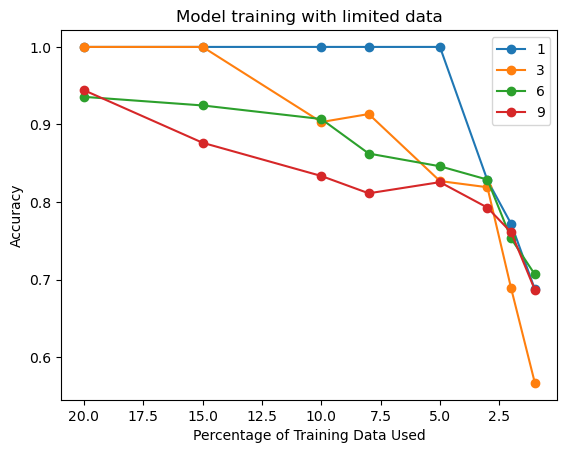

In [28]:
plt.plot(percentages, a4, marker='o', label='1')
plt.plot(percentages, a1, marker='o', label='3')
plt.plot(percentages, a2, marker='o', label='6')
plt.plot(percentages, a3, marker='o', label='9')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Accuracy')
plt.title('Model training with limited data')

plt.gca().invert_xaxis()
plt.legend()
plt.savefig("limiteddata.png")
plt.show()